# Régression

## Objectif

Dans cette partie "Régression", on cherche à prédire les émissions de CO2 de voitures, en se basant sur leurs caractéristiques \(poids, carburant utilisé, etc\). L'objectif est de minimiser la moyenne des erreurs absolues entre les valeurs prédites et les valeurs réelles.

## Traitement des données

### Importation des dépendances

Nous importons les dépendances python en début de fichier pour faciliter leur installation.

In [53]:
import matplotlib.pyplot as plt # pour afficher des graphiques
import missingno as msno # visualiser les données manquantes
import copy # copier des données
import seaborn as sns # visualisation des données
import pandas as pd # lire et modifier les données
import numpy as np # algebre linéaire

import torch
import torch.nn as nn # pour le réseau de neurones (neural network)
import torch.nn.functional as F # pour la fonction d'activation
from torch.utils import data  # pour la gestion des données
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import train_test_split # pour split les données
from sklearn.model_selection import KFold # pour l'entrainement en KFold

### Chargement des données

Nos données d'entraînement sont situées dans des fichiers CSV. 

Dans un premier temps, on cherche donc à charger ces données CSV avec Pandas.

In [4]:
# on charge le fichier train
df_train_raw = pd.read_csv('dataset/train.csv')

# le nombre de lignes et colonnes
print(df_train_raw.shape)

(41257, 20)


### Visualisation des données
On visualise les premières lignes ainsi que la distribution des voitures selon leur émission de CO2

In [5]:
df_train_raw.head()

,id,brand,model,car_class,range,fuel_type,hybrid,max_power,grbx_type_ratios,weight_min,weight_max,urb_cons,exturb_cons,overall_cons,co,hc,nox,hcnox,ptcl,co2
0,0,MERCEDES,COMBI 110 CDI,MINIBUS,MOY-INFER,GO,non,70.0,M 6,1976,2075,9.1,6.4,7.4,0.083,NaN,0.229,0.250,0.001,195
1,1,MERCEDES,VIANO 2.0 CDI,MINIBUS,MOY-SUPER,GO,non,100.0,A 5,2186,2355,10.2,7.0,8.2,0.078,NaN,0.224,0.233,0.001,216
2,2,MERCEDES,SPRINTER COMBI 319 CDI,MINIBUS,MOY-INFER,GO,non,140.0,A 5,2586,2869,12.5,9.0,10.3,0.067,0.014,1.846,NaN,0.002,272
3,3,RENAULT,MEGANE Coupé EnergyTCe (115ch) eco2,COUPE,MOY-INFER,ES,non,85.0,M 6,1280,1280,6.4,4.6,5.3,0.167,0.039,0.039,NaN,0.001,119
4,4,MERCEDES,COMBI 116 CDI,MINIBUS,MOY-INFER,GO,non,120.0,A 5,2356,2450,10.1,6.9,8.1,0.042,NaN,0.190,0.201,0.001,214


<Axes: xlabel='co2', ylabel='Count'>

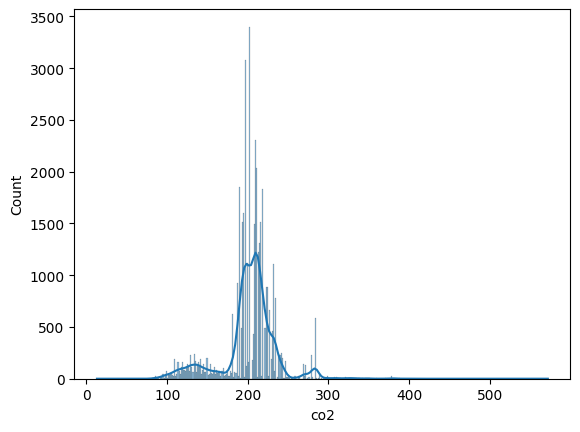

In [166]:
sns.histplot(df_train_raw['co2'], kde=True)

On regarde ensuite les données manquantes. Les espaces blanches montrent les valeurs vides. 

On observe que les colonnes hc et hcnox manquent beaucoup de données.

<Axes: >

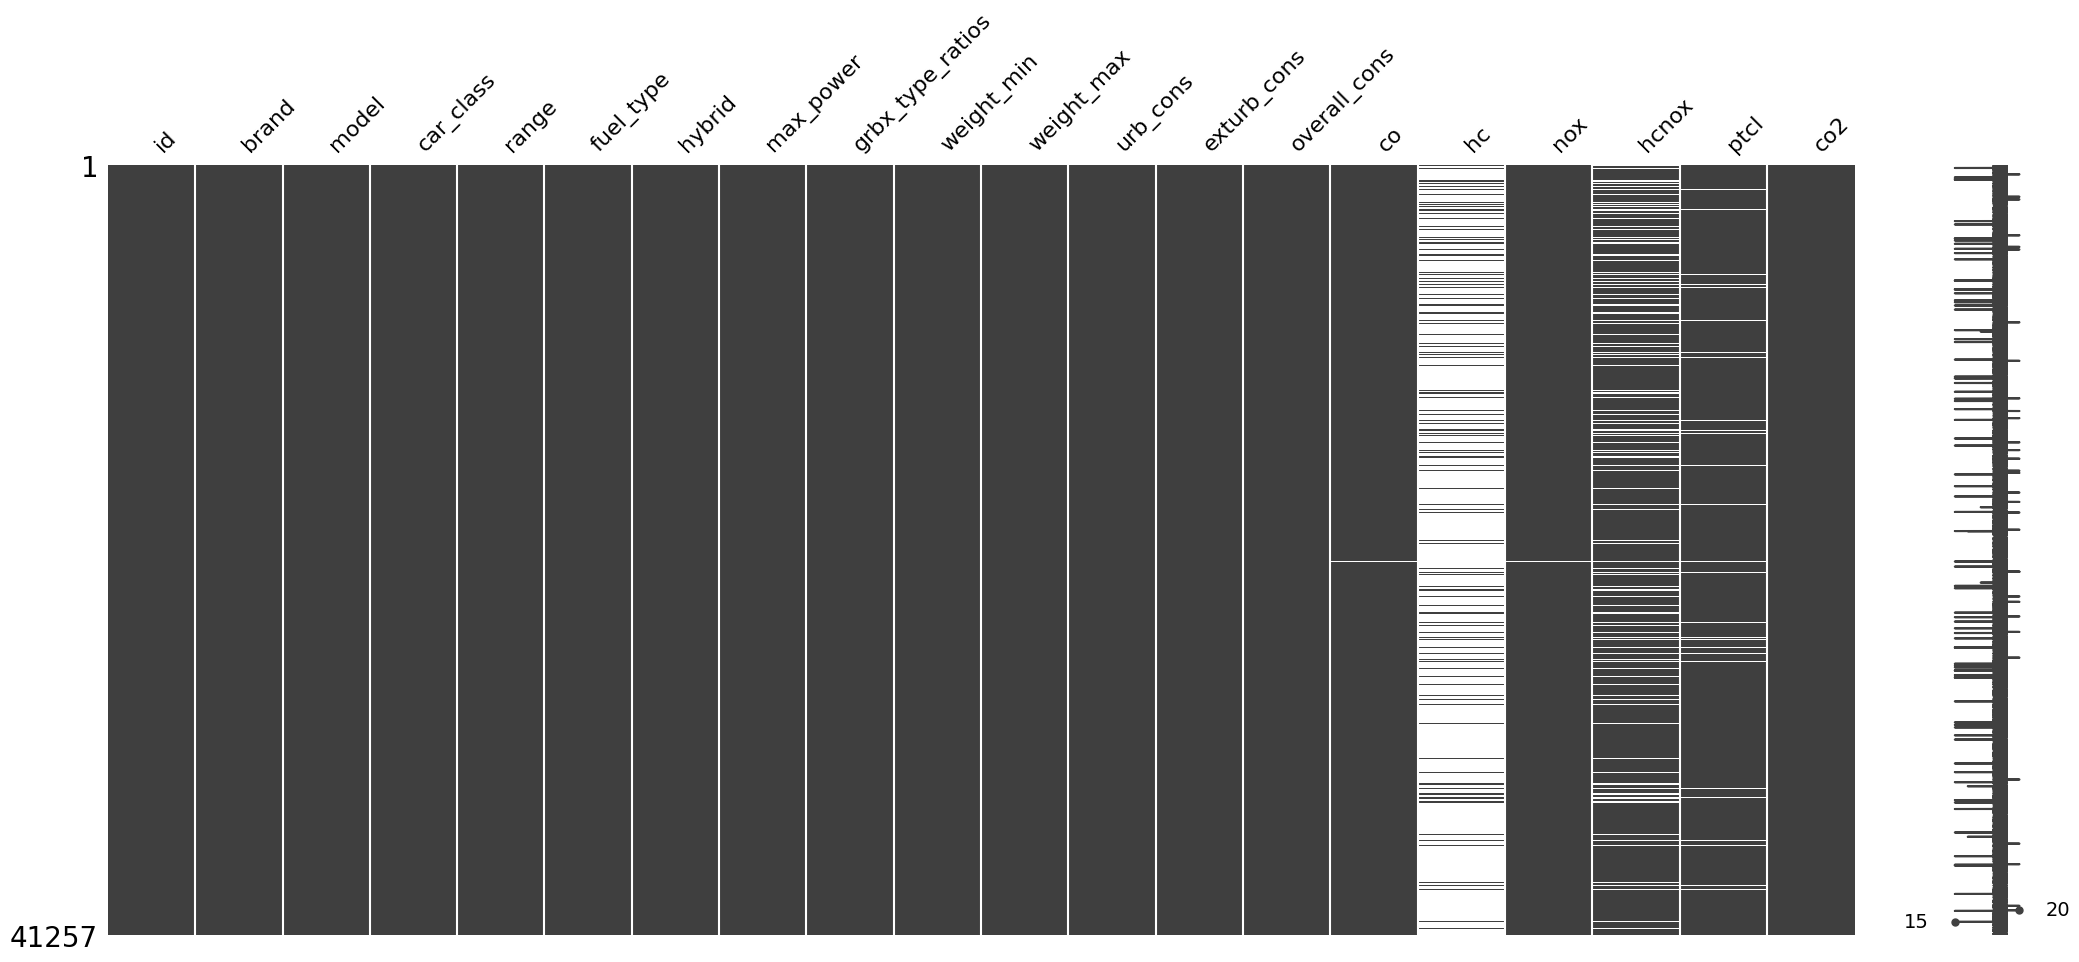

In [7]:
msno.matrix(df_train_raw)

### Nettoyage des données 

On supprime les colonnes non utilisées tels que la colonne id, co2 et les colonnes non-numériques. 
On supprime aussi les colonnes hc et hcnox qui sont partiellement vides.
On normalise les valeurs numériques.

In [8]:
# Preprocessing function
def preprocess(df):
    df = df.copy() # Make copy so we don't ruin the original dataframe
    df = df.drop(columns=["id"], errors='ignore') # Drop id column
    
    numeric_cols = df.select_dtypes(np.number).columns # Numerical column name
    numeric_cols = numeric_cols.drop("co2", errors='ignore')

    categorical_cols = df.select_dtypes(include=['object']).columns # Categorical column name

    # on supprime les colonnes inutiles ou trop différents
    categorical_cols = categorical_cols.drop("model", errors='ignore')
    
    df_categorical = pd.get_dummies(df[categorical_cols], dummy_na=True) # OneHotEncoding, dummy_na create another column to indicate if the cell contain NA
    
    df_numerical = df[numeric_cols].apply(lambda x: (x - x.mean()) / (x.std())) # Normalize every numerical column
    df_numerical = df_numerical.fillna(0) # Fill in missing value with mean 0
    
    df = pd.concat([df_numerical, df_categorical], axis=1) # Bind numerical column and categorical column
    df = df.replace({ True: 1, False: 0 })
    
    return df

On récupère ensuite les entrées et la cible (le target)

In [169]:
# Get inputs and target
df_train_y = df_train_raw["co2"].copy() # Copy the target
df_train_y = np.log(df_train_y, where=df_train_y != 0) # Scale the target
df_train_X = preprocess(df_train_raw) # Preprocess the inputs

On observe à nouveau les données après nettoyage

In [170]:
df_train_X.head()

,max_power,weight_min,weight_max,urb_cons,exturb_cons,overall_cons,co,hc,nox,hcnox,...,grbx_type_ratios_D 5,grbx_type_ratios_D 6,grbx_type_ratios_D 7,grbx_type_ratios_M 5,grbx_type_ratios_M 6,grbx_type_ratios_M 7,grbx_type_ratios_S 6,grbx_type_ratios_V .,grbx_type_ratios_V 0,grbx_type_ratios_nan
0,-1.081718,-0.431682,-0.631718,-0.226067,-0.317075,-0.262402,-0.674873,0.000000,-0.170262,0.436865,...,0,0,0,0,1,0,0,0,0,0
1,-0.419211,0.283063,0.029746,0.302782,0.262150,0.317846,-0.709297,0.000000,-0.182196,-0.018312,...,0,0,0,0,0,0,0,0,0,0
2,0.464131,1.644483,1.244003,1.408557,2.192902,1.840997,-0.785028,-0.638620,3.689150,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,-0.750465,-2.800552,-2.509802,-1.524150,-2.054752,-1.785552,-0.096561,0.643276,-0.623749,0.000000,...,0,0,0,0,1,0,0,0,0,0
4,0.022460,0.861667,0.254171,0.254705,0.165612,0.245316,-0.957145,0.000000,-0.263346,-0.875114,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='co2', ylabel='Count'>

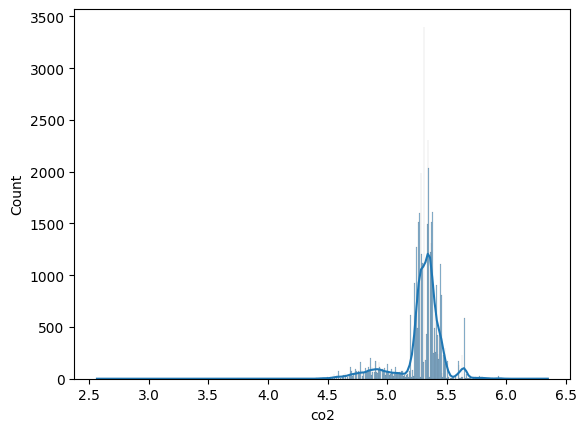

In [171]:
sns.histplot(df_train_y, kde=True)

### Séparation des données
On "split" ensuite les données pour utiliser 80% pour l'entrainement et 20% pour la validation

In [172]:
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_train_X, df_train_y, train_size=0.8, random_state=42)

## Construction du modèle

D'abord on construit un premier modèle dit "pyramidal". L'idée est de partir avec un nombre d'entrées fixé, correspondant aux caractéristiques de nos voitures. Dans notre cas, on commence pour l'instant avec les 11 paramètres numériques présents dans nos données \(en enlevant les paramètres "id" et "co2"\). On place ensuite une première couche cachée avec un grand nombre de neurones, avant de faire décroître ce nombre sur les couches suivantes.

On y ajoute aussi la fonction d'activation ReLU (Rectified Linear Unit). Elle calcule simplement le maximum entre 0 et le niveau d'activation du neurone.



In [173]:
# Building a model
class Model(nn.Module):
    def __init__(self, D_in=108, H=73, D_out=1, Hn=4):
        super().__init__()
        self.Hn = Hn # Number of hidden layer
        self.activation = nn.Softplus() # Activation function
        
        self.layers = nn.ModuleList([nn.Linear(D_in, H), self.activation]) # First hidden layer
        for i in range(self.Hn - 1):
            self.layers.extend([nn.Linear(H, H), self.activation]) # Add hidden layer
        self.layers.append(nn.Linear(H, D_out)) # Output layer
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Entrainement du modèle

Une fois le réseau de neurone défini, on va entraîner ce modèle. Pour l'entraînement, on définit une fonction de perte qui nous permettra de quantifier l'écart entre les prévisions et les observations réelles. On utilise pour cela la fonction MSE (Mean Square Error) : $$ MSE = \frac{1}{n} \sum_{i=1}^{n} (\hat{Y_i} - Y_i)^2$$

Pour optimiser le processus, on utilise l'algorithme Adam. Cet algorithme implémente une méthode stochastique très efficace de descente de gradient pour modifier les poids des neurones à chaque itération de l'entraînement.



On met en place un seed pour avoir les mêmes résultats à chaque éxécution, ce qui va faciliter le débuggage.

In [174]:
# Setting seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# Set seed for reproducibility
set_seed(123)

On utilise la carte graphique avec CUDA si disponible, sinon le processeur

In [175]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# force cpu
device = "cpu"

print(device)

cpu


On génère les données que l'on va utiliser pour la validation

In [176]:
y_val = torch.tensor(df_val_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_val = torch.tensor(df_val_X.values).float().to(device)

Préparation des données pour l'apprentissage par renforcement hors ligne

In [177]:
y_train = torch.tensor(df_train_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_train = torch.tensor(df_train_X.values).float().to(device)
dataset = TensorDataset(X_train, y_train) # Make X,y into dataset so we can work with DataLoader which iterate our data in batch size
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

On initialise le modèle, définit l'optimiseur et la fonction perte

In [178]:
model = Model().to(device) # Define model and send to gpu
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001) # What approach we use to minimize the gradient
criterion = nn.MSELoss() # Our loss function

On entraîne le modèle (explications ?)

In [179]:
train_losses = [] # Store the training loss
val_losses = [] # Store the validation loss
epochs = 100 # Number of time we go over the whole dataset

for epoch in range(epochs):
    running_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        # Forward propagation
        y_pred = model(X) # Make prediction by passing X to our model
        loss = criterion(y_pred, y) # Calculate loss 
        running_loss += loss.item() # Add loss to running loss
        
        # Backward propagation
        optimizer.zero_grad() # Empty the gradient (look up this function)
        loss.backward() # Do backward propagation and calculate the gradient of loss with respect to every parameters (that require gradient)
        optimizer.step() # Adjust parameters to minimize loss
    
    # Append train loss
    train_losses.append(running_loss/(batch + 1)) # Add the average loss of this iteration to training loss
    
    # Check test loss
    y_pred = model(X_val)
    val_loss = criterion(y_pred, y_val).item()
    val_losses.append(val_loss)
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Evaluation du modèle

Fonctions pour visualiser l'écart entre les prévisions du modèle et les observations réelles

In [180]:
# Plotting loss
def plot_loss(losses, axes=None, epoch_start = 0):
    sns.set_theme(style="darkgrid")
    x = [i for i in range(1 + epoch_start, len(losses) + 1)]
    sns.lineplot(ax=axes, x=x, y=losses[epoch_start:])
    
    
def plot_epoch_loss(train_losses, test_losses, epoch1=0, epoch2=10, epoch3=50, epoch4=150):
    fig, axes = plt.subplots(2, 2, figsize=(12,6), constrained_layout = True)
    fig.suptitle("Losses against Epochs")

    axes[0][0].set_title('Epoch Start at ' + str(epoch1))
    plot_loss(train_losses, axes[0][0], epoch1)
    plot_loss(test_losses, axes[0][0], epoch1)

    axes[0][1].set_title('Epoch Start at ' + str(epoch2))
    plot_loss(train_losses, axes[0][1], epoch2)
    plot_loss(test_losses, axes[0][1], epoch2)

    axes[1][0].set_title('Epoch Start at ' + str(epoch3))
    plot_loss(train_losses, axes[1][0], epoch3)
    plot_loss(test_losses, axes[1][0], epoch3)

    axes[1][1].set_title('Epoch Start at ' + str(epoch4))
    plot_loss(train_losses, axes[1][1], epoch4)
    plot_loss(test_losses, axes[1][1], epoch4)

    plot_epoch_loss(train_losses, val_losses)

Fonctions pour calculer les erreurs

In [181]:
def numpy_error(model, X, y, exp=True):
    y_pred = model(X)
    if exp:
        y = torch.exp(y)
        y_pred = torch.exp(y_pred)

    errors = (y_pred - y).flatten().detach().cpu().numpy()
    return errors

# Calculate the mean absolute error
def mae(errors):
    return np.abs(errors).mean()

# Calculate the root mean squared error
def rmse(errors):
    mse = ((errors)**2).mean()
    return np.sqrt(mse)

On affiche les erreurs

In [182]:
# Error on full training set 
errors = numpy_error(model, X_train, y_train, False)
print("Error on training set")
print(f"MAE: {mae(errors)}\nRMSE: {rmse(errors)}")

# Error on testing set
errors = numpy_error(model, X_val, y_val, False)
print("\nError on testing set")
print(f"MAE: {mae(errors)}\nRMSE: {rmse(errors)}")

Error on training set
MAE: 0.00909782201051712
RMSE: 0.023324372246861458

Error on testing set
MAE: 0.00917208380997181
RMSE: 0.02273467183113098


## Essai du modèle

On charge le fichier de test

In [183]:
df_test = pd.read_csv('dataset/test.csv')
submission_id = df_test["id"].copy()

On regarde les données manquantes

In [184]:
# Check for missing columns on submission inputs (after preprocessing)
X_submission = preprocess(df_test)
train_cols = df_train_X.columns
submission_cols = X_submission.columns
diff = train_cols.difference(submission_cols)

print(diff)

Index(['brand_SSANGYONG', 'car_class_COMBISPCACE', 'fuel_type_GL',
       'grbx_type_ratios_S 6', 'grbx_type_ratios_V .'],
      dtype='object')


On essaye de corriger les données manquantes en ajoutant des lignes pour les valeurs manquantes pour chaque colonne

In [185]:
added_rows = 0 
idx = len(df_test) # Where added row should be modified

df_test_copy = df_test.copy() # Copy so we don't ruin the dataframe
eg_row = df_test.iloc[0] # Example row

for string in diff:
    df_test_copy = pd.concat([df_test_copy, pd.DataFrame([eg_row])], ignore_index=True)
    col, value = string.rsplit('_', 1) # Split into column and value
    df_test_copy.loc[idx, col] = value
    idx += 1
    added_rows += 1


On nettoie les données

In [186]:
df_test_copy = preprocess(df_test_copy) # Preprocess the copy
X_submission = df_test_copy.drop(df_test_copy.tail(added_rows).index) # Remove the added rows
X_submission = torch.tensor(X_submission.values).float().to(device) # Change it into tensor for our model

On génère notre soumission

In [187]:
y_submission = model(X_submission).squeeze() # Make it into array
y_submission = torch.exp(y_submission) # Scale back to normal value 
y_submission = y_submission.cpu().detach().numpy() # Change to numpy
submission = pd.DataFrame({"id":submission_id, "co2":y_submission}) # Make dataframe for submission
submission.to_csv('submission.csv', index=False) # Put into csv file

# Regréssion avec Scikit learn

Dans cette partie, nous allons reprendre notre reégrression linéaire mais avec la bibliothèque Scikit-learn, qui propose des modèles tres interessants

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
import pandas as pd
import sklearn

In [73]:
df = pd.read_csv("dataset/train.csv")

On a remarqué que hcnox = hc +nox

Ainsi, on peut donc retrouver les valeurs nulles dans la colonne hc. Une fois cela fait, on supprime la colonne hcnox.

In [74]:
# Vérifier si la colonne "hcnox" est vide
is_empty = (df['hc'].isnull() & df['hcnox'].notnull() & df['nox'].notnull())

# Remplir les valeurs manquantes dans "hcnox" avec la somme de "hc" et "nox"
df.loc[is_empty,'hc'] = df.loc[is_empty,'hcnox'] - df.loc[is_empty,'nox']
df = df.drop(columns=["hcnox"])

In [75]:
median = df['ptcl'].median()
df['ptcl'].fillna(median, inplace=True)
df = df.dropna()

C:\Users\dilan\AppData\Local\Temp\ipykernel_12224\3012464913.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ptcl'].fillna(median, inplace=True)


<Axes: >

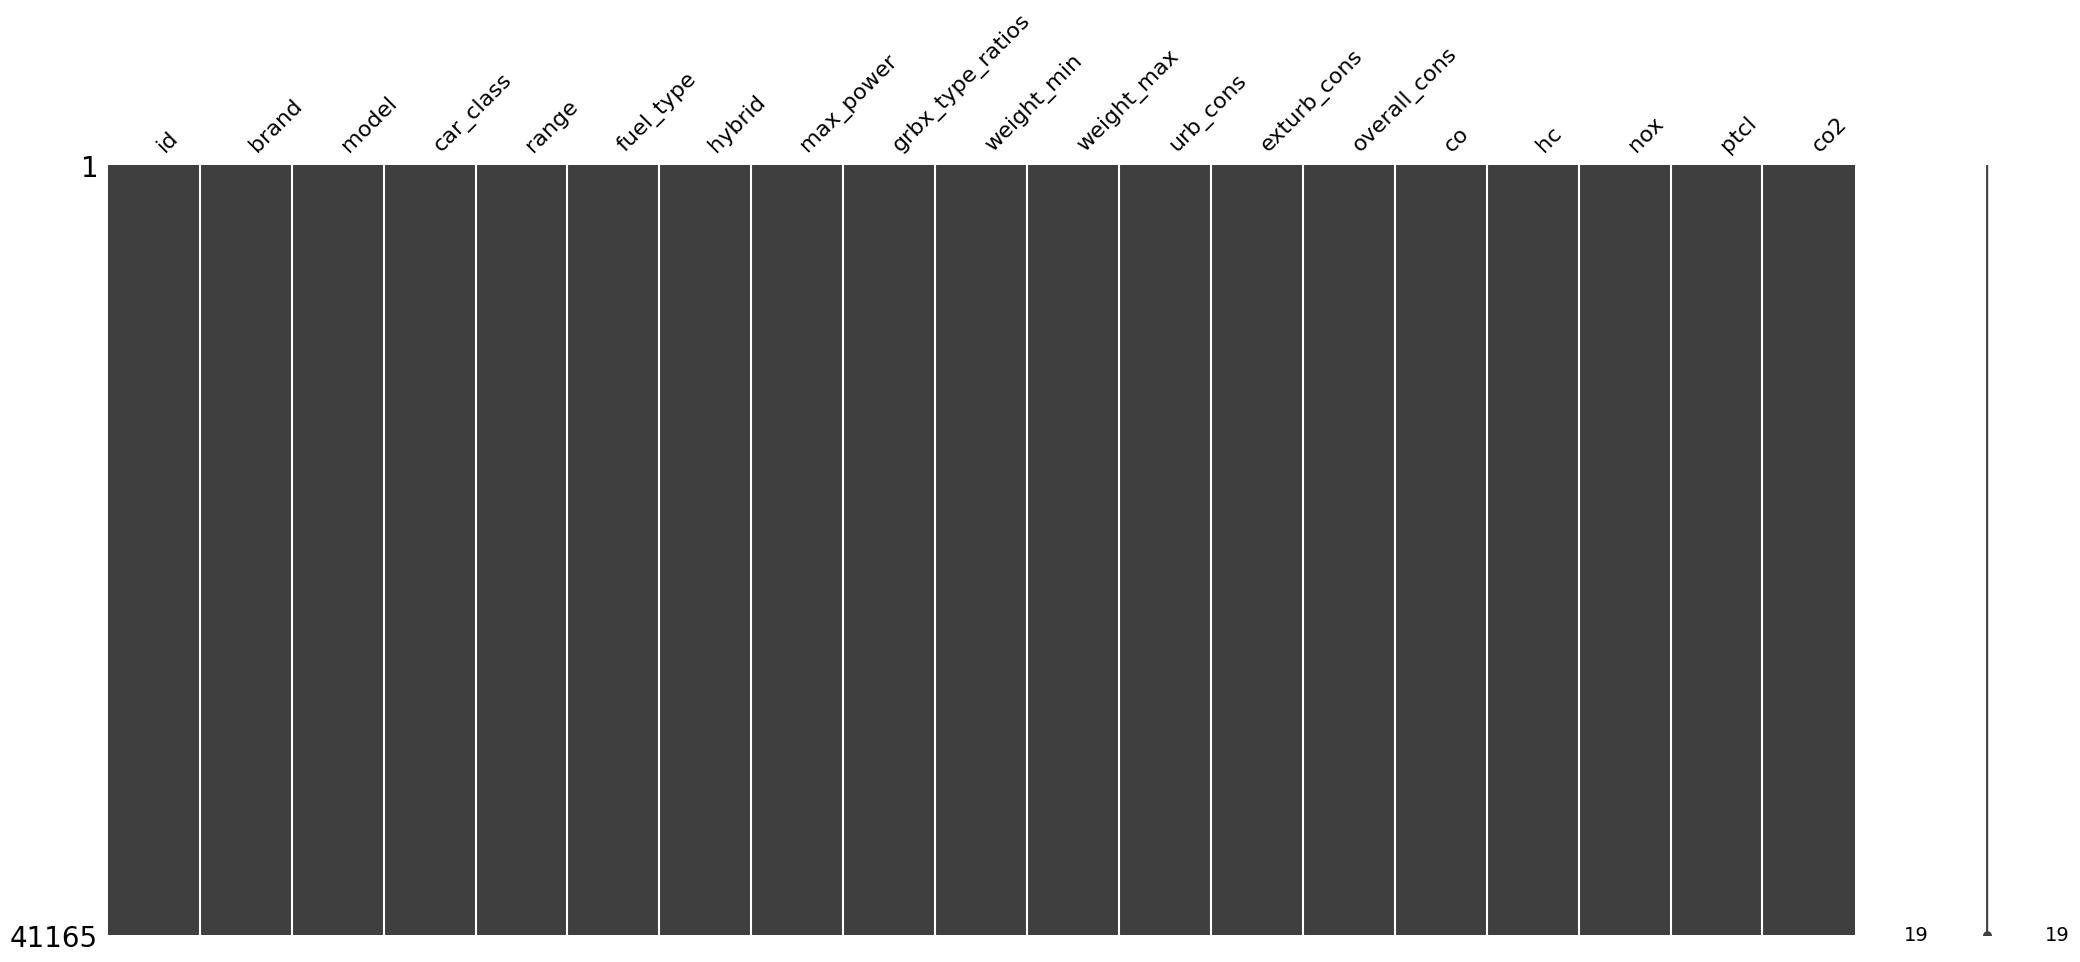

In [76]:
msno.matrix(df)

On supprime la colonne "id". On sépare la cible des autres variables

In [77]:
target_name = "co2"
target, data = df[target_name] , df.drop(columns=[target_name,"id"])   #On sépare la colonne target des autres colonnes

Sélection des variables numériques et catégoriques

In [78]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [82]:
#prétraitement des variables
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

#Notre modèle qui est un pipeline, standarisation des données puis, regréssion logistique
preprocessors = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

## AdaBoost

In [ ]:
ada = make_pipeline(preprocessors, AdaBoostRegressor(n_estimators=4000, learning_rate=1.0, loss='linear'))
ada_regressor = ada.fit(data,target)

## RidgeCV

In [147]:
alphas = np.logspace(-5, 5, num=101)
ridge = make_pipeline(preprocessors, RidgeCV(alphas=alphas,cv=2))

cv_results = cross_validate(
    model, data, target, cv=3, return_estimator=True,
    return_train_score=True, scoring="neg_mean_squared_error"
)
ridge_regressor = ridge.fit(data,target)

In [148]:
scores_train=-cv_results["train_score"]
scores_test=-cv_results["test_score"]

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:\n"
      f"{scores_train.mean():.3f} ± {scores_train.std():.3f}")

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:\n"
      f"{scores_test.mean():.3f} ± {scores_test.std():.3f}")

Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:
0.225 ± 0.010
Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:
0.282 ± 0.040


In [170]:
from sklearn.impute import SimpleImputer
data_test = pd.read_csv('dataset/test.csv')
column_id = data_test["id"]
data_test = data_test.drop(columns=["id","hc"])

imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
df_hcnox =imputer.fit_transform(data_test[["hcnox"]])
data_test["hcnox"]=df_hcnox

df_co = imputer.fit_transform(data_test[["co"]])
data_test["co"]=df_co

df_nox = imputer.fit_transform(data_test[["nox"]])
data_test["nox"]=df_nox

df_urb_cons = imputer.fit_transform(data_test[["urb_cons"]])
data_test["urb_cons"]=df_urb_cons

df_exturb_cons = imputer.fit_transform(data_test[["exturb_cons"]])
data_test["exturb_cons"]=df_exturb_cons

df_ptcl = SimpleImputer(fill_value=np.nan, strategy='median').fit_transform(data_test[["ptcl"]])
data_test["ptcl"]=df_ptcl

predictions = model.predict(data_test)

result_df = pd.DataFrame({'id': column_id, 'co2': predictions})
result_df.to_csv("predictions.csv", index=False)

In [169]:
data_test.isnull().sum()

brand               0
model               0
car_class           0
range               0
fuel_type           0
hybrid              0
max_power           0
grbx_type_ratios    0
weight_min          0
weight_max          0
urb_cons            3
exturb_cons         3
overall_cons        0
co                  0
nox                 0
hcnox               0
ptcl                0
dtype: int64

## Régression linéaire

In [112]:
from sklearn.linear_model import LinearRegression
model2 = make_pipeline(preprocessors, LinearRegression())
cv_results2 = cross_validate(
    model2, data, target, cv=2, return_estimator=True,
    return_train_score=True, scoring="neg_mean_squared_error"
)
scores_train2=-cv_results2["train_score"]
scores_test2=-cv_results2["test_score"]

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:\n"
      f"{scores_train2.mean():.3f} ± {scores_train2.std():.3f}")

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:\n"
      f"{scores_test2.mean():.3f} ± {scores_test2.std():.3f}")
#ExtraTreesRegressor(n_estimators=10, max_features=32, random_state=0),

Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:
0.206 ± 0.001
Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:
0.628 ± 0.089


## K Nearest Neighbors

In [145]:
model3 = make_pipeline(preprocessors, KNeighborsRegressor(n_neighbors=5,weights="distance",p=1))
cv_results3 = cross_validate(
    model3, data, target, cv=2, return_estimator=True,
    return_train_score=True, scoring="neg_mean_squared_error"
)

scores_train3=-cv_results3["train_score"]
scores_test3=-cv_results3["test_score"]

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:\n"
      f"{scores_train3.mean():.3f} ± {scores_train3.std():.3f}")

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:\n"
      f"{scores_test3.mean():.3f} ± {scores_test3.std():.3f}")

Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:
0.005 ± 0.000
Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:
1.760 ± 0.431


In [100]:
from sklearn.ensemble import GradientBoostingRegressor
model5 = make_pipeline(preprocessors, GradientBoostingRegressor(n_estimators=1000, max_features=20))
cv_results5 = cross_validate(
    model5, data, target, cv=2, return_estimator=True,
    return_train_score=True, scoring="neg_mean_squared_error"
)

scores_train5=-cv_results5["train_score"]
scores_test5=-cv_results5["test_score"]

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:\n"
      f"{scores_train5.mean():.3f} ± {scores_train5.std():.3f}")

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:\n"
      f"{scores_test5.mean():.3f} ± {scores_test5.std():.3f}")


Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:
4.937 ± 0.449
Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:
10.236 ± 1.854


In [117]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
 
#reg = StackingRegressor(estimators=RidgeCV(alphas=alphas,cv=2),final_estimator=KNeighborsRegressor(n_neighbors=20,weights="distance",p=1))
r1 = RidgeCV(alphas=alphas,cv=2)
r2 = KNeighborsRegressor(n_neighbors=20,weights="distance",p=1)
model4 = make_pipeline(preprocessors,VotingRegressor(estimators=[('lr',r1),('rf',r2)]))

In [118]:
cv_results4 = cross_validate(
    model4, data, target, cv=2, return_estimator=True,
    return_train_score=True, scoring="neg_mean_squared_error"
)

scores_train4=-cv_results4["train_score"]
scores_test4=-cv_results4["test_score"]

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:\n"
      f"{scores_train4.mean():.3f} ± {scores_train4.std():.3f}")

print(f"Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:\n"
      f"{scores_test4.mean():.3f} ± {scores_test4.std():.3f}")

Erreur quadratique moyenne du modèle de régression linéaire sur les données d'entrainement:
0.064 ± 0.000
Erreur quadratique moyenne du modèle de régression linéaire sur les données de test:
0.896 ± 0.103
